# MLP with floating point weights and baremetal C implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

import src.python.dataset.yalefaces as yalefaces
import src.python.model.util as util

np.random.seed(99)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load dataset
### Load and normalize the raw dataset

In [4]:
X, y = yalefaces.load("dataset/yalefaces", flatten=True)
X = X.astype("float32") / 255.0

### Compress dataset with PCA

In [5]:
num_faces, num_pixels = X.shape
num_principal_components = int(num_faces)

pca = PCA(n_components=num_principal_components)
pca.fit(X)

X_compressed = pca.transform(X)

### Split dataset into train and test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_compressed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

## Train MLP

In [7]:
class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(165, 96, bias=True),
      torch.nn.ReLU(),
      torch.nn.Linear(96, 15, bias=True),
    )

  def forward(self, x):
    return self.layers(x)

In [8]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

In [9]:
train_accs= []
train_losses = []

for epoch in range(200):
    train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    error, num_samples = util.train(model, device, train_data, optimizer)
    loss = float(error)/float(num_samples)
    train_losses.append(loss)
    
    acc = util.test(model, device, train_data)
    train_accs.append(acc)

Text(0.5, 1.0, 'Accuracy')

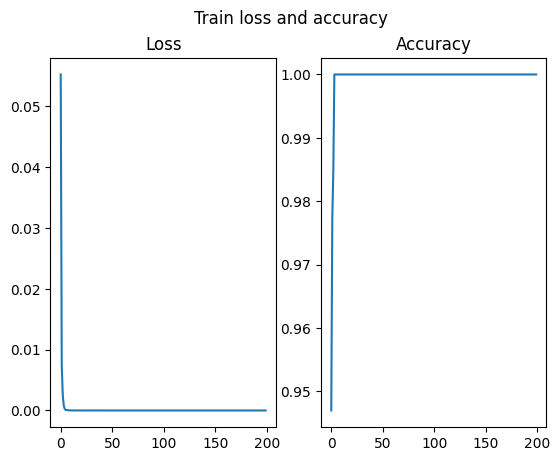

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Train loss and accuracy')

ax1.plot(train_losses)
ax1.set_title("Loss")

ax2.plot(train_accs)
ax2.set_title("Accuracy")

In [11]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = util.test(model, device, test_data)
print(f"Test accuracy: {acc * 100:.2f}")

Test accuracy: 81.82


## Export model weights as C code

In [12]:
model_params=model.state_dict()

In [264]:
print(model_params)

OrderedDict([('layers.0.weight', tensor([[ 5.6058e-02,  1.3414e-01, -3.7215e-02,  ...,  1.4643e-09,
         -2.6780e-08,  1.2370e-08],
        [-3.2355e-02, -5.9503e-02,  1.3228e-01,  ...,  2.3216e-08,
          2.8908e-09, -5.6209e-09],
        [ 3.8460e-02, -3.1022e-02,  3.7237e-02,  ...,  1.0164e-07,
          1.0195e-07,  2.5676e-07],
        ...,
        [-4.9205e-02, -1.2664e-01, -1.4132e-02,  ..., -6.3461e-08,
          3.5415e-08, -3.0264e-08],
        [-5.7907e-02,  1.2991e-01,  4.6328e-02,  ...,  4.9185e-08,
          1.0679e-08,  8.4430e-08],
        [ 1.0170e-01,  8.4723e-02, -1.5700e-01,  ...,  5.9975e-10,
         -5.2355e-08, -2.3367e-08]])), ('layers.0.bias', tensor([ 0.0060,  0.0448,  0.0144, -0.0360, -0.0373, -0.0199, -0.0139,  0.0023,
         0.0403, -0.0223,  0.0110,  0.0511,  0.0280,  0.0122, -0.0144,  0.0847,
        -0.0097, -0.0255, -0.0032, -0.0809,  0.0073,  0.0266, -0.0500,  0.0492,
         0.0068,  0.0017, -0.0068,  0.0404, -0.0036,  0.0014, -0.0296,  0.0

In [31]:
layer_indexes = [0, 2]

with open('src/embedded/1-mlp-baremetal-float/esp32s3/main/mlp_weights.c', 'w') as source, open('src/embedded/1-mlp-baremetal-float/esp32s3/include/mlp_weights.h', 'w') as header:
    
    header.write('#ifndef MLP_WEIGHTS\n#define MLP_WEIGHTS\n\n')
    header.write('#include <stdint.h>\n\n')
    
    source.write('#include "mlp_weights.h"\n\n')

    for layer in layer_indexes:
        weights = util.get_weights(model_params, layer).flatten()
        bias = util.get_bias(model_params, layer)
        bias = (bias.reshape((bias.shape[0],1))).flatten()

        # Weights
        header.write(f"extern const float layer_{layer}_weights[{len(weights)}];\n")
        source.write(f"const float layer_{layer}_weights[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{weights[i]}, ")
        source.write(f"{weights[len(weights)-1]}}};\n\n")

        # Bias
        header.write(f"extern const float layer_{layer}_bias[{len(bias)}];\n")
        source.write(f"const float layer_{layer}_bias[{len(bias)}] = {{")
        for i in range(len(bias)-1):
            source.write(f"{bias[i]}, ")
        source.write(f"{bias[len(bias)-1]}}};\n\n")

    header.write('\n#endif // end of MLP_PARAMS\n')

In [34]:
def relu(x):
    return x * (x > 0)


layer_indexes = [0, 2]
face = X_test[12]
expected = y_test[12]

x = face
x = x.reshape((165,1))


weights = util.get_weights(model_params, 0)
bias = util.get_bias(model_params, 0)
bias = bias.reshape((bias.shape[0],1))

print(weights.shape, bias.shape, x.shape)
print(weights[0:10])
print(bias[0:10])

y = weights@x
print(y.shape)

y = y+bias
y = relu(y)
x = y


weights = util.get_weights(model_params, 2)
bias = util.get_bias(model_params, 2)
bias = bias.reshape((bias.shape[0],1))

print(weights.shape, bias.shape, x.shape)

y = weights@x
y = y+bias

print(np.argmax(y), expected)



(96, 165) (96, 1) (165, 1)
[[-8.0471121e-02  3.5137434e-02 -4.6209332e-02 ... -2.4498030e-07
  -2.3012687e-08 -1.5369335e-07]
 [ 7.4327826e-02 -5.9132963e-02  7.5081877e-02 ...  2.1258716e-08
  -2.7715906e-08  4.3838526e-08]
 [-5.6186069e-02  4.4158748e-03 -8.6124465e-02 ... -9.2006751e-08
  -3.1611094e-08 -2.3503672e-07]
 ...
 [ 8.8999532e-03  7.0336811e-02  2.5640461e-03 ... -1.4641481e-07
  -5.4789410e-08  1.1073923e-06]
 [ 9.2730867e-03  2.6465464e-02 -1.5466584e-01 ...  5.5848915e-08
  -1.7151386e-08 -9.4994022e-09]
 [ 1.4059463e-01 -1.4234808e-01 -3.0184884e-03 ... -8.1475960e-08
  -1.1686666e-07  1.1933655e-07]]
[[-0.03537565]
 [-0.0115639 ]
 [ 0.01251604]
 [ 0.02737738]
 [-0.02270303]
 [ 0.0324869 ]
 [-0.06266496]
 [-0.00968288]
 [-0.02865187]
 [-0.01072748]]
(96, 1)
(15, 96) (15, 1) (96, 1)
7 7


## Talk to esp32

In [39]:
import time
import serial

with serial.Serial("/dev/ttyUSB0", 115200, timeout=None) as esp32:
    esp32.read_until(b'Ready\n')
    
    num_tests = len(X_test)
    num_correct = 0
    
    for i in range(num_tests):
        face = X_test[i]
        expected = y_test[i]

        msg = esp32.read(18)
        assert msg == b'Waiting for input\n'

        esp32.write(b'\x01')

        msg = esp32.read(14)
        assert msg == b'Reading input\n'

        esp32.write(face.tobytes())
        # esp32.write((face.astype(float)).tobytes())

        msg = esp32.read(11)
        assert msg == b'Processing\n'

        subject = esp32.read(4)
        subject = int.from_bytes(subject, byteorder="little")

        if expected == subject:
            num_correct += 1
            status='OK'
        else:
            status='FAIL'

        print(f"{status} - Expected: {expected}, got: {subject}")
    acc = num_correct/num_tests
    print(f"Accuracy: {acc}%")



FAIL - Expected: 13, got: 14
OK - Expected: 5, got: 5
OK - Expected: 10, got: 10
OK - Expected: 11, got: 11
OK - Expected: 2, got: 2
OK - Expected: 4, got: 4
OK - Expected: 6, got: 6
OK - Expected: 5, got: 5
OK - Expected: 4, got: 4
FAIL - Expected: 12, got: 6
OK - Expected: 10, got: 10
FAIL - Expected: 3, got: 8
OK - Expected: 7, got: 7
OK - Expected: 3, got: 3
OK - Expected: 8, got: 8
OK - Expected: 2, got: 2
OK - Expected: 12, got: 12
OK - Expected: 8, got: 8
OK - Expected: 9, got: 9
OK - Expected: 0, got: 0
FAIL - Expected: 1, got: 14
OK - Expected: 3, got: 3
OK - Expected: 6, got: 6
OK - Expected: 14, got: 14
OK - Expected: 9, got: 9
FAIL - Expected: 0, got: 3
OK - Expected: 13, got: 13
OK - Expected: 6, got: 6
OK - Expected: 7, got: 7
FAIL - Expected: 12, got: 6
OK - Expected: 14, got: 14
OK - Expected: 1, got: 1
OK - Expected: 11, got: 11
Accuracy: 0.8181818181818182%
